# Laboratorio 1
## Integrantes:
- José Antonio Mérida -- 201105
- Joaquín Puente -- 22296 

### Imports y Funciones de Utilidad

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

def plot_walk_forward(
    train, test, preds, 
    col=None, 
    title="Walk Forward Validation", 
    ylabel="Value"
):
    import matplotlib.pyplot as plt
    import pandas as pd
    from sklearn.metrics import mean_squared_error
    import numpy as np

    if col is None:
        col = train.columns[0] if hasattr(train, "columns") else None
        if col is None:
            raise ValueError("Column name must be provided if train/test are Series.")

    preds_series = pd.Series(preds, index=test.index)

    plt.figure(figsize=(10, 5))

    train_plus_first_test = pd.concat([train, test.iloc[:1]])

    plt.plot(
        train_plus_first_test.index, train_plus_first_test[col],
        color='blue', linewidth=2, label='Observed (Train)', zorder=2
    )

    plt.plot(
        test.index, test[col],
        color='green', linewidth=2, label='Observed (Test)', zorder=3
    )

    plt.plot(
        preds_series.index, preds_series,
        color='red', linestyle='--', linewidth=2, label='Prediction', zorder=4
    )

    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.legend()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.show()

    rmse = np.sqrt(mean_squared_error(test[col], preds))
    print(f"RMSE: {rmse:.2f}")
    return rmse

## shampoo.csv

### 1. Análisis Exploratorio

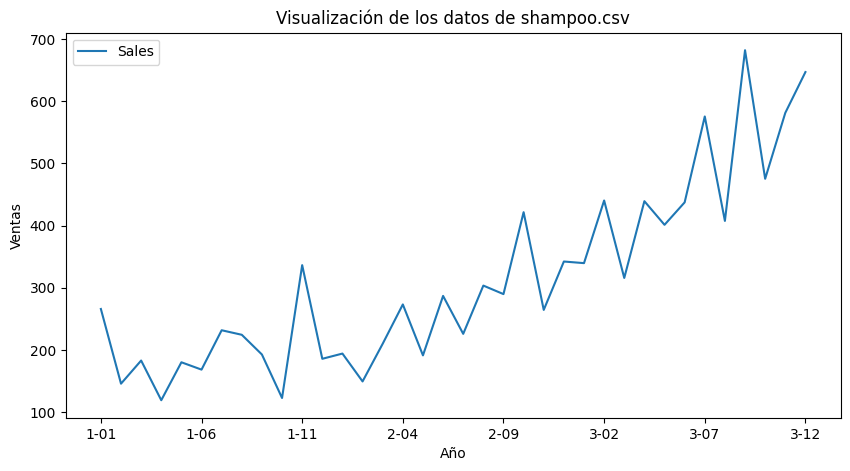

In [102]:
filename = 'shampoo.csv'
datos = pd.read_csv(f'datasets/{filename}',
                    index_col='Month',
                    parse_dates=True)

datos.index.freq = 'MS'

datos.plot(label='Observados', figsize=(10, 5))

plt.legend()
plt.title(f"Visualización de los datos de {filename}")
plt.xlabel("Año")
plt.ylabel("Ventas")
plt.show()

Durante todo el primer a;o no parece existir algun patron de crecimiento, sin embargo luego parece existir un trend donde las ventas aumentan conforme el tiempo. Adicionalmente, cada a;o suele tener picos especialmente en los ultimos meses del a;o (por ejemplo 1-11, 2-10 y 3-12) lo cual nos indica que existe un factor estacional. En cuanto al dataset en si, podemos ver que la informacion esta dividida en meses y realmente no hay una cantidad grande de datos. Podemos predecir lo siguiente basados en la grafica:

- Los modelos sin un factor estacional se quedaran por debajo de los picos, a pesar de captar el trend de crecimiento.
- Los modelos que pongan un mayor enfasis a los datos mas recientes para predecir trends tendran un mejor rendimiento, ya que el trend se empieza a mostrar en fechas mas recientes.
- Los modelos mas efectivos seran los que incluyen factor estacional y trends, como Holt-Winters, SARIMA o Prophet.
- Al tener una cantidad de datos reducidos, el modelo de Prophet tendra un rendimiento menor al esperado.

Para realizar predicciones con el modelo, decidimos utilizar 7 puntos de prueba de los 29 disponibles.

In [103]:
train_size = 29
train = datos.iloc[:train_size]
test = datos.iloc[train_size:]

### 2. Promedios Móviles

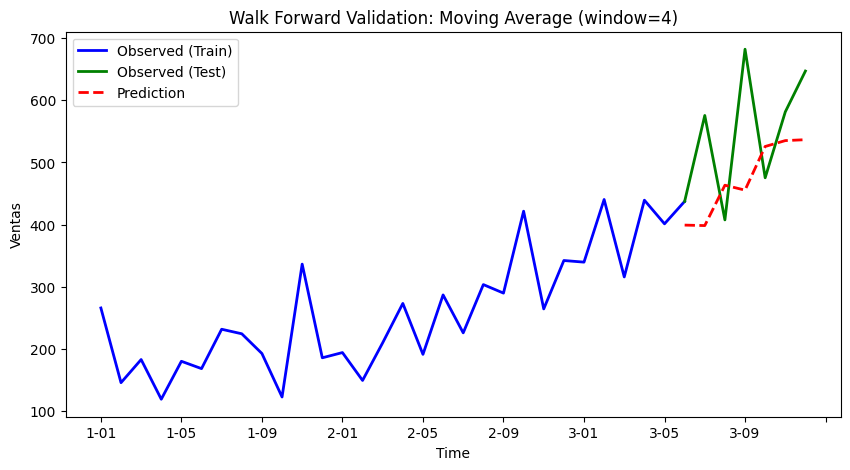

RMSE: 121.93


np.float64(121.93388284523003)

In [104]:
window = 4
history = list(train['Sales'])
preds = []

for t in range(len(test)):
    if len(history) >= window:
        pred = np.mean(history[-window:])
    else:
        pred = np.mean(history)
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title="Walk Forward Validation: Moving Average (window=4)",
    ylabel="Ventas"
)

El modelo de Moving Average tuvo un RMSE de 121.93, visualizando la grafica nos damos cuenta que nuestra prediccion fue correcta. Al no incluir un factor estacional, el modelo es incapaz de predecir los altos picos que se suelen dar en algunos de los ultimos meses del a;o a pesar de captar correctamente el trend. Podemos intentar utilizar un Gridsearch para variar los parametros y encontrar una mejor solucion al problema.

Window: 2, RMSE: 113.15
Window: 3, RMSE: 111.51
Window: 4, RMSE: 121.93
Window: 5, RMSE: 119.48
Window: 6, RMSE: 132.06
Window: 7, RMSE: 137.13
Window: 8, RMSE: 146.07
Window: 9, RMSE: 151.57
Window: 10, RMSE: 159.67
Window: 11, RMSE: 164.96
Window: 12, RMSE: 173.24

Best window: 3 with RMSE: 111.51


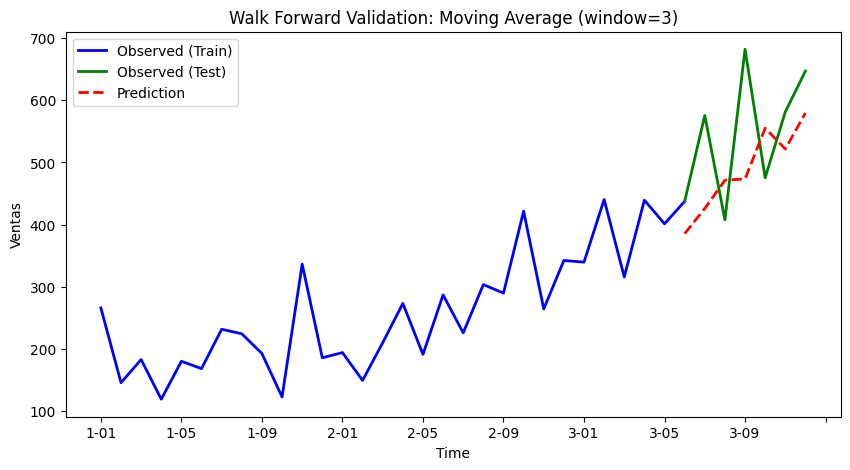

RMSE: 111.51


np.float64(111.5106230258761)

In [105]:
best_rmse = float('inf')
best_window = None
best_preds = None

for window in range(2, 13):
    history = list(train['Sales'])
    preds = []
    for t in range(len(test)):
        if len(history) >= window:
            pred = np.mean(history[-window:])
        else:
            pred = np.mean(history)
        preds.append(pred)
        history.append(test['Sales'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
    print(f"Window: {window}, RMSE: {rmse:.2f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_window = window
        best_preds = preds

print(f"\nBest window: {best_window} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Walk Forward Validation: Moving Average (window={best_window})",
    ylabel="Ventas"
)

Este modelo tuvo un RMSE de 111.51, lo cual es considerablemente mejor que el anterior. Esto tambien se evidencia por medio de la grafica, donde parece que una ventana mas peque;a permite al modelo enfocarse mas en el ultimo pico de ventas. Esto lleva a valores mas cercanos a los reales, sin embargo, el modelo sigue estando limitado por la falta de componente estacional.

### 3. Alisamiento Exponencial

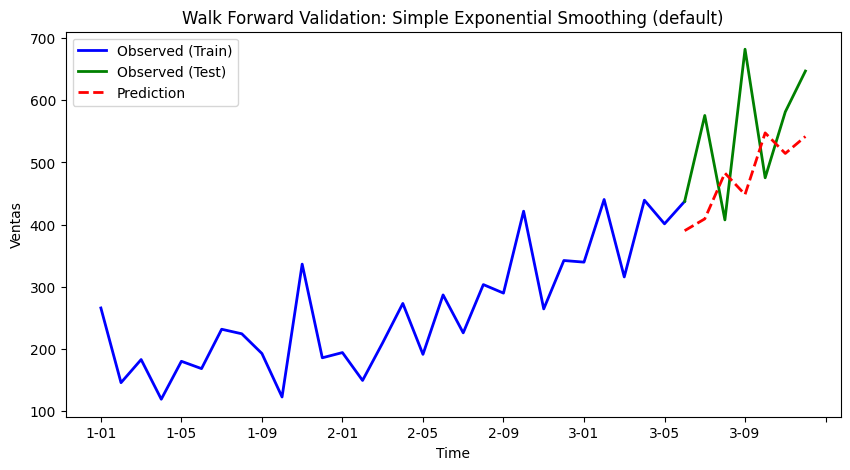

RMSE: 125.84


np.float64(125.84098732784979)

In [106]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

history = list(train['Sales'])
preds = []

for t in range(len(test)):
    model = SimpleExpSmoothing(history).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title="Walk Forward Validation: Simple Exponential Smoothing (default)",
    ylabel="Ventas"
)

Este modelo tuvo un RMSE de 125, dentro de la grafica podemos ver que fue incapaz de predecir los cambios estacionales y tampoco fue capaz de ajustarse al ultimo pico de ventas. Ya que SES utiliza smoothing, en este caso es menos efectivo que Moving Averages. Podemos utilizar Gridsearch para variar los parametros y explorar si el mismo modelo con diferentes parametros es capaz de captar el ultimo pico de una manera mas precisa.

Best alpha: 0.43 with RMSE: 123.99


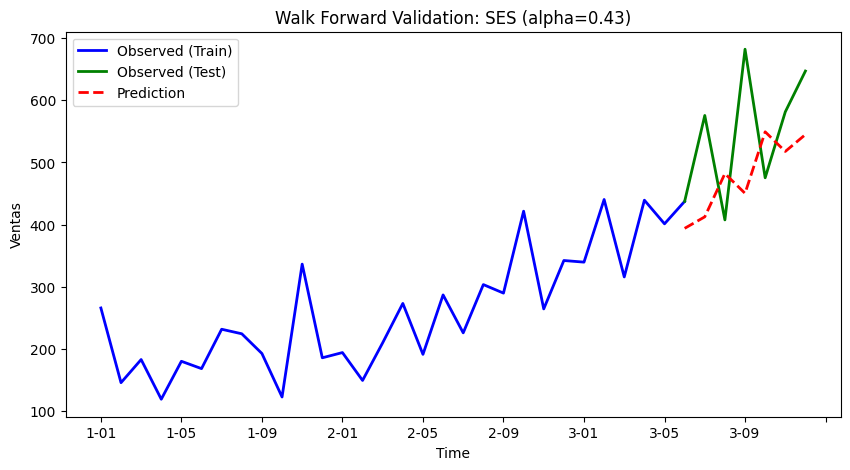

RMSE: 123.99


np.float64(123.98648446926198)

In [107]:
import numpy as np

alphas = np.linspace(0.01, 1.0, 20)
best_rmse = float('inf')
best_alpha = None
best_preds = None

for alpha in alphas:
    history = list(train['Sales'])
    preds = []
    for t in range(len(test)):
        model = SimpleExpSmoothing(history).fit(smoothing_level=alpha, optimized=False)
        pred = model.forecast(1)[0]
        preds.append(pred)
        history.append(test['Sales'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
        best_preds = preds

print(f"Best alpha: {best_alpha:.2f} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Walk Forward Validation: SES (alpha={best_alpha:.2f})",
    ylabel="Ventas"
)

Luego de variar los parametros, los resultados son bastante similares. Podemos afirmar que no es ideal utilizar un SES para resolver este problema, debido a su falta de factor estacional y capacidad de 'reaccionar' rapidamente a cambios mas abruptos.

### 4. Holt winters

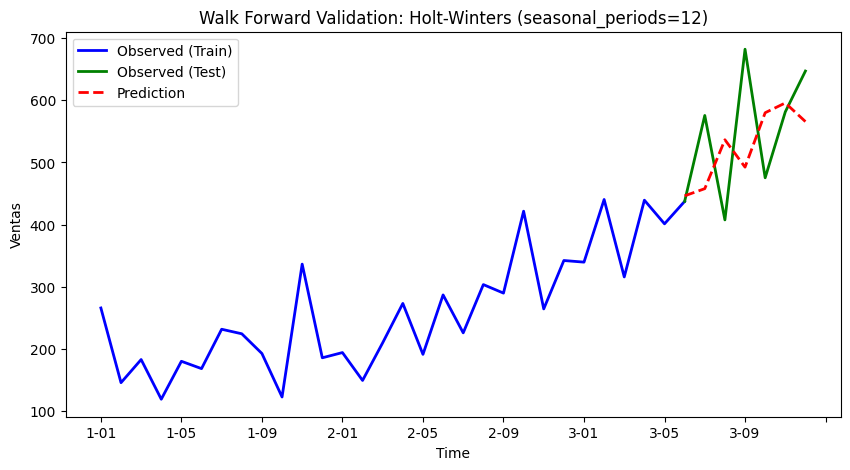

RMSE: 109.69


np.float64(109.68535930057814)

In [108]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

seasonal_periods = 12

history = list(train['Sales'])
history_index = list(train.index)
preds = []

for t in range(len(test)):
    model = ExponentialSmoothing(
        history,
        trend='add',
        seasonal='add',
        seasonal_periods=seasonal_periods
    ).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Sales'].iloc[t])
    history_index.append(test.index[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title=f"Walk Forward Validation: Holt-Winters (seasonal_periods={seasonal_periods})",
    ylabel="Ventas"
)

Con un RMSE de 109.69, el modelo Holt-Winters es el mas prometedor hasta el momento. Este es el primer modelo que probamos en este dataset que incorpora factor estacional, lo cual se puede apreciar claramente dentro de la grafica. Al incorporar el factor estacional, se puede capturar el trend con tecnicas de smoothing (sin tener que 'reaccionar' rapidamente al ultimo pico como en Moving Averages) y aun asi tener predicciones precisas. Podemos utilizar un Gridsearch para buscar una solucion mas optima al problema.

trend=add, seasonal=add, seasonal_periods=4, RMSE=125.73
trend=add, seasonal=add, seasonal_periods=6, RMSE=107.30
trend=add, seasonal=add, seasonal_periods=12, RMSE=109.69
trend=add, seasonal=None, seasonal_periods=4, RMSE=101.61
trend=add, seasonal=None, seasonal_periods=6, RMSE=101.61
trend=add, seasonal=None, seasonal_periods=12, RMSE=101.61
trend=None, seasonal=add, seasonal_periods=4, RMSE=145.45
trend=None, seasonal=add, seasonal_periods=6, RMSE=134.71
trend=None, seasonal=add, seasonal_periods=12, RMSE=136.27

Best parameters:
trend=add, seasonal=None, seasonal_periods=4, RMSE=101.61


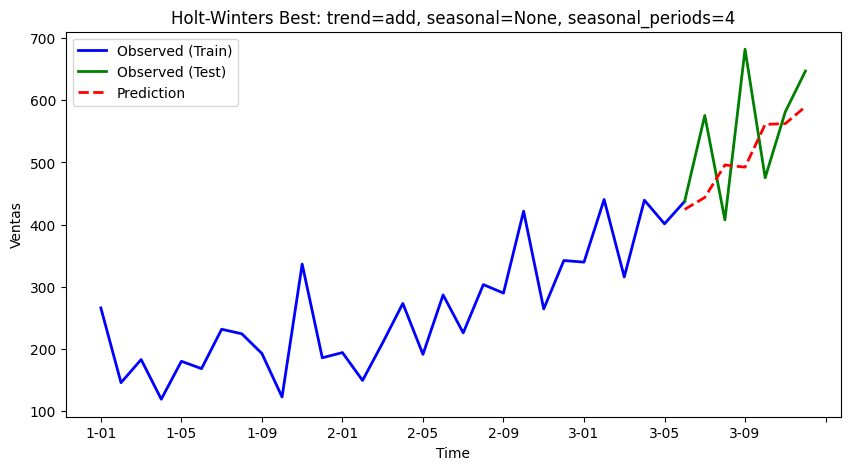

RMSE: 101.61


np.float64(101.61194599324081)

In [109]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

trend_options = ['add', None]
seasonal_options = ['add', None]
seasonal_periods_options = [4, 6, 12]

best_rmse = float('inf')
best_params = None
best_preds = None

for trend in trend_options:
    for seasonal in seasonal_options:
        if trend is None and seasonal is None:
            continue
        for seasonal_periods in seasonal_periods_options:
            history = list(train['Sales'])
            preds = []
            try:
                for t in range(len(test)):
                    model = ExponentialSmoothing(
                        history,
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=seasonal_periods
                    ).fit(optimized=True)
                    pred = model.forecast(1)[0]
                    preds.append(pred)
                    history.append(test['Sales'].iloc[t])
                rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
                print(f"trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods}, RMSE={rmse:.2f}")
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (trend, seasonal, seasonal_periods)
                    best_preds = preds
            except Exception as e:
                print(f"FAILED: trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods} ({e})")

print("\nBest parameters:")
print(f"trend={best_params[0]}, seasonal={best_params[1]}, seasonal_periods={best_params[2]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Holt-Winters Best: trend={best_params[0]}, seasonal={best_params[1]}, seasonal_periods={best_params[2]}",
    ylabel="Ventas"
)

Luego de realizar un gridsearch, obtenemos el valor mas bajo de RMSE hasta el momento con 101.61. Podemos darnos cuenta tambien dentro de la grafica que predice mejor el incremento el ventas al final de la grafica. Tomando en cuenta el comportamiento erratico al final de nuestros datos, podemos concluir que este modelo fue bastante exitoso prediciendo ventas.

### 5. SARIMA

First test index: 3-06
First prediction index: 3-06
First test value: 437.4
First prediction value: 463.7983884895966


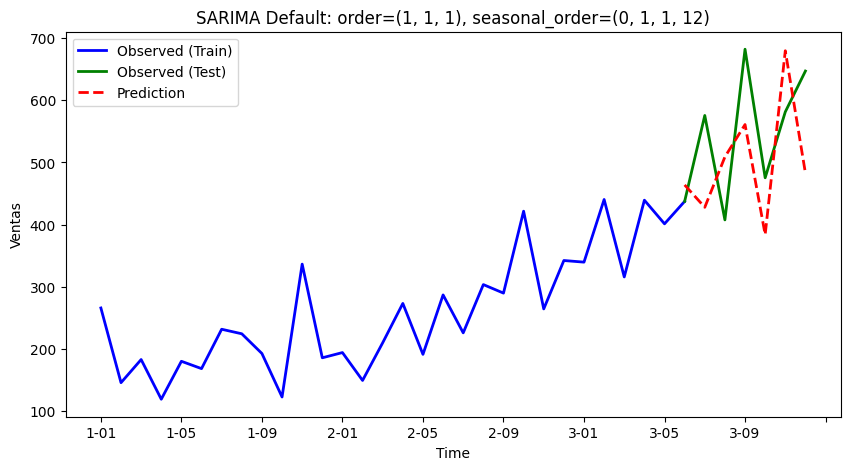

RMSE: 114.88


np.float64(114.87521713673407)

In [110]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

history = list(train['Sales'])
preds = []

order = (1, 1, 1)
seasonal_order = (0, 1, 1, 12)

for t in range(len(test)):
    model = SARIMAX(
        history,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

print("First test index:", test.index[0])
print("First prediction index:", test.index[0])  # preds_series uses test.index
print("First test value:", test['Sales'].iloc[0])
print("First prediction value:", preds[0])

plot_walk_forward(
    train, test, preds, col='Sales',
    title=f"SARIMA Default: order={order}, seasonal_order={seasonal_order}",
    ylabel="Ventas"
)

Tomando el cuenta el RMSE, el modelo no es tan prometedor. Sin embargo, viendo la grafica nos podemos dar cuenta que es el unico hasta el momento que predice valores bastante cercanos para los meses de ventas pico. Podemos realizar un Gridsearch para encontrar una mejor solucion.

................................................................
Best parameters:
order=(1, 0, 1), seasonal_order=(1, 0, 1, 12), RMSE=88.19


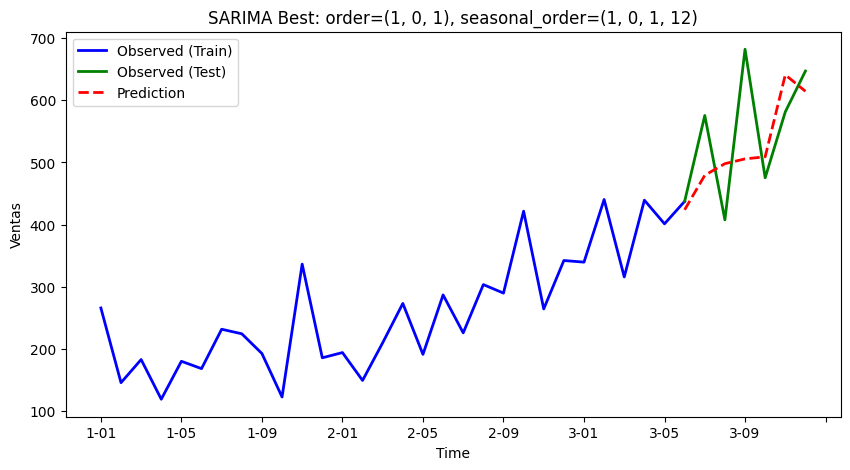

RMSE: 88.19


np.float64(88.18507296980404)

In [111]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import numpy as np
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = [12]

param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

best_rmse = float('inf')
best_params = None
best_preds = None

for idx, (p_, d_, q_, P_, D_, Q_, s_) in enumerate(param_combinations):
    history = list(train['Sales'])
    preds = []
    try:
        for t in range(len(test)):
            model = SARIMAX(
                history,
                order=(p_, d_, q_),
                seasonal_order=(P_, D_, Q_, s_),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            pred = model.forecast(1)[0]
            preds.append(pred)
            history.append(test['Sales'].iloc[t])
        rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = ((p_, d_, q_), (P_, D_, Q_, s_))
            best_preds = preds
        print('.', end='', flush=True)
    except Exception:
        print('x', end='', flush=True)

print("\nBest parameters:")
print(f"order={best_params[0]}, seasonal_order={best_params[1]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"SARIMA Best: order={best_params[0]}, seasonal_order={best_params[1]}",
    ylabel="Ventas"
)

Luego del Gridsearch, tuvimos como resultado un RMSE de 88.19, el mas bajo hasta el momento. Esto nos indica que este modelo es capaz de captar trends de crecimiento, factores estacionales al igual que otros indicadores para realizar predicciones a futuro. Observando la grafica, el modelo no fue capaz de predecir el comportamiento erratico dentro de los primeros maximos y minimos. Sin embargo, si fue capaz de realizar predicciones bastante precisas entre estos picos. Por ultimo, fue capaz de encontrar el ultimo trend de crecimiento, algo que no hemos visto por parte de los demas modelos.

### 6. Prophet

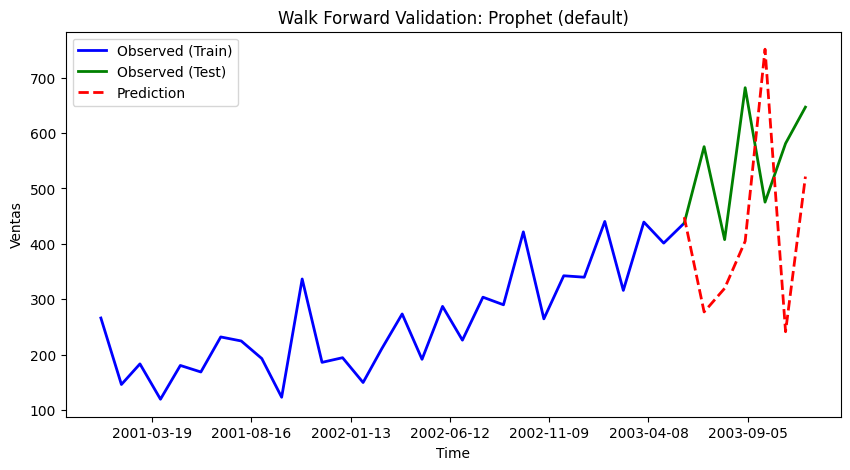

RMSE: 233.47


np.float64(233.46545015561264)

In [112]:
import pandas as pd
from prophet import Prophet

if not pd.api.types.is_datetime64_any_dtype(train.index):
    train = train.copy()
    test = test.copy()
    train['Month'] = pd.date_range(start='2001-01', periods=len(train), freq='MS')
    test['Month'] = pd.date_range(start=train['Month'].iloc[-1] + pd.offsets.MonthBegin(1), periods=len(test), freq='MS')
    train.set_index('Month', inplace=True)
    test.set_index('Month', inplace=True)

train_prophet = train.reset_index().rename(columns={train.index.name or 'index': 'ds', 'Sales': 'y'})
test_prophet = test.reset_index().rename(columns={test.index.name or 'index': 'ds', 'Sales': 'y'})

train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

history = train_prophet.copy()
preds = []

for t in range(len(test)):
    m = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
    m.fit(history)
    future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
    forecast = m.predict(future)
    pred = forecast['yhat'].values[0]
    preds.append(pred)
    history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)

plot_walk_forward(
    train, test, preds, col='Sales',
    title="Walk Forward Validation: Prophet (default)",
    ylabel="Ventas"
)

En este caso, Prophet tuvo un rendimiento sumamente pobre. Las predicciones fueron bastante malas y no fue capaz de ajustarse correctamente. Esto nos puede decir que al tener un conjunto de datos con poca cantidad, se presenta un caso de over-fitting donde el modelo es demasiado flexible y se sobreajusta a los datos.


Best params: mode=additive, changepoint_prior_scale=0.1, RMSE=214.66


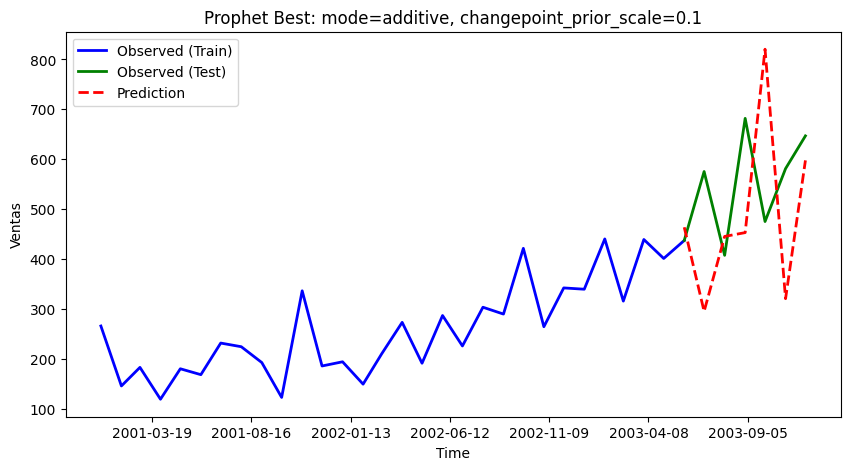

RMSE: 214.66


np.float64(214.6608062514054)

In [113]:
from prophet import Prophet
import numpy as np

seasonality_modes = ['additive', 'multiplicative']
changepoint_scales = [0.01, 0.1, 0.5]

best_rmse = float('inf')
best_params = None
best_preds = None

for mode in seasonality_modes:
    for cps in changepoint_scales:
        history = train_prophet.copy()
        preds = []
        try:
            for t in range(len(test)):
                m = Prophet(
                    yearly_seasonality=True,
                    daily_seasonality=False,
                    weekly_seasonality=False,
                    seasonality_mode=mode,
                    changepoint_prior_scale=cps
                )
                m.fit(history)
                future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
                forecast = m.predict(future)
                pred = forecast['yhat'].values[0]
                preds.append(pred)
                history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)
            rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (mode, cps)
                best_preds = preds
        except Exception as e:
            print(f"FAILED: mode={mode}, changepoint_prior_scale={cps} ({e})")

print(f"\nBest params: mode={best_params[0]}, changepoint_prior_scale={best_params[1]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Prophet Best: mode={best_params[0]}, changepoint_prior_scale={best_params[1]}",
    ylabel="Ventas"
)

Luego de realizar un Gridsearch, podemos concluir que Prophet no es la herramienta adecuada para resolver este problema. Puede que para otros sets de datos dentro de este reporte sea mas apropiado.

### 7. Comparacion y Evaluacion

En el caso de 'shampoo.csv', el mejor modelo fue SARIMA luego de realizar un Gridsearch. Los resultados fueron similares a lo que esperabamos, ya que los modelos sin factor estacional se quedan por detras al unicamente captar trend con RMSE's de 111 y 124 respectivamente. Luego, para Holt-Winters y ARIMA tuvimos RMSE's de 108 y 81. Esta diferencia la podemos explicar debido a la diferencia entre ambos, donde las relaciones entre puntos de este dataset pueden tener patrones mas complejos como autocorrelacion. En este caso, SARIMA tuvo la capacidad de realizar mejores predicciones. Por ultimo, Prophet tuvo un rendimiento sumamente pobre con un RMSE de 214 debido a la baja cantidad de datos y posible sobreajuste al ser un modelo bastante flexible.

## monthly-mean-temp.csv

### 1. Análisis Exploratorio

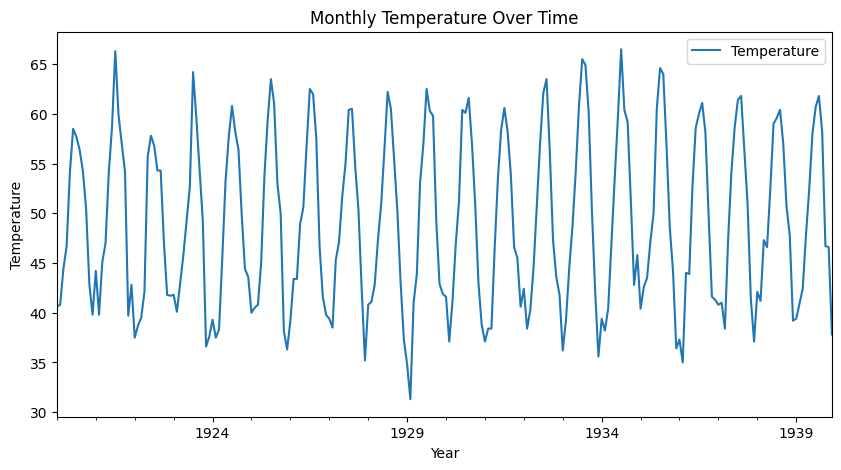

In [114]:
filename = 'monthly-mean-temp.csv'
df = pd.read_csv(f'datasets/{filename}', index_col='Month', parse_dates=True)
df.index.freq = 'MS'

train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

df.plot(figsize=(10, 5), label='Temperature')
plt.title("Monthly Temperature Over Time")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.legend()
plt.show()

Para este dataset contamos con temperaturas promedio por mes a lo largo de un periodo de tiempo, en este caso podemos observar que realmente no existe un trend hacia arriba. Sin embargo, existen muy altas tendencias estacionales. Esto es de esperarse, ya que la mayoria de variacion en temperatura se da a lo largo de diferentes temporadas de un a;o. Gracias a esto, podemos predecir lo siguiente

- Los modelos sin factor estacional seran completamente incapaces de realizar predicciones
- Los modelos con un factor estacional tendran un rendimiento alto
- SES tendra un mejor rendimiento que Moving Averages al tener un promedio mas alisado a lo largo del tiempo.

### 2. Promedios móviles

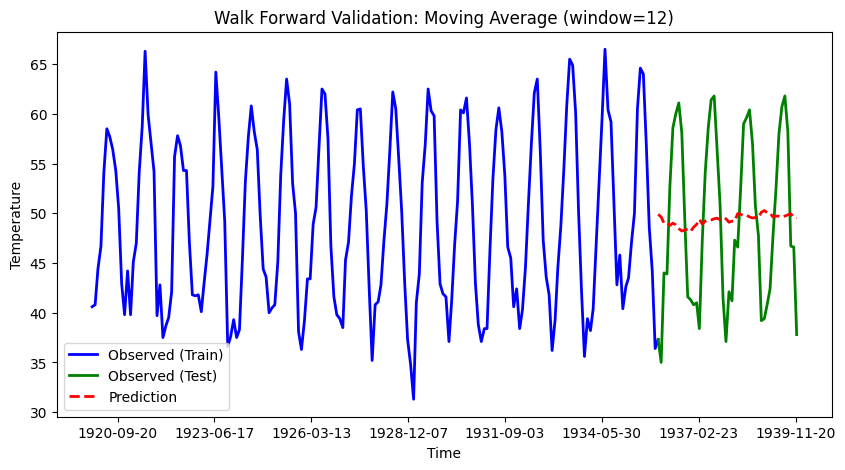

RMSE: 8.38


np.float64(8.384285724286922)

In [115]:
window = 12
history = list(train['Temperature'])
preds = []

for t in range(len(test)):
    if len(history) >= window:
        pred = np.mean(history[-window:])
    else:
        pred = np.mean(history)
    preds.append(pred)
    history.append(test['Temperature'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Temperature',
    title=f"Walk Forward Validation: Moving Average (window={window})",
    ylabel="Temperature"
)

Empezando con unos parametros baseline bastante simples, el modelo presenta un RMSE de 8.38. Considerando la escala del modelo un RMSE de 8 grados es sumamente malo, esto se debe a los intervalos grandes de window=12 al igual que la simplicidad del modelo y la ausencia de componente estacional. Al variar parámetros podemos optar por tamaños de window más reducidos para intentar ver la diferencia.

Window: 2, RMSE: 6.60
Window: 3, RMSE: 8.14
Window: 4, RMSE: 9.40
Window: 5, RMSE: 10.34
Window: 6, RMSE: 10.95
Window: 7, RMSE: 11.17
Window: 8, RMSE: 11.02
Window: 9, RMSE: 10.56
Window: 10, RMSE: 9.89
Window: 11, RMSE: 9.11
Window: 12, RMSE: 8.38
Window: 13, RMSE: 7.86
Window: 14, RMSE: 7.66
Window: 15, RMSE: 7.77

Best window: 2 with RMSE: 6.60


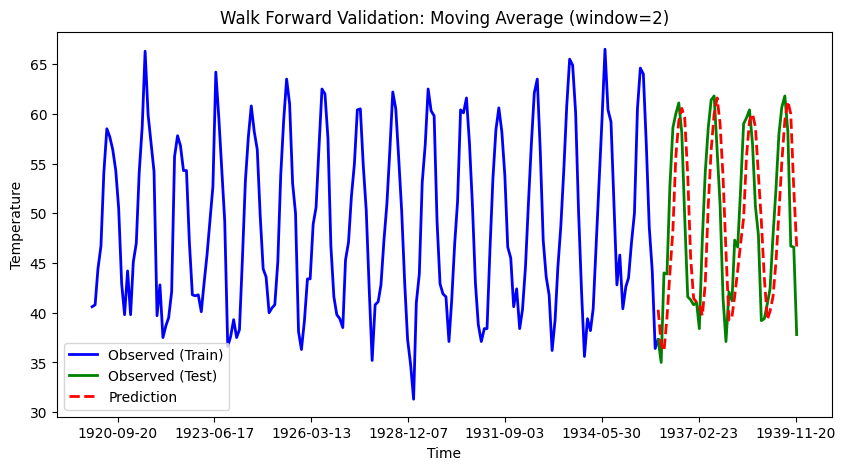

RMSE: 6.60


np.float64(6.595216069242917)

In [116]:
from sklearn.metrics import mean_squared_error
import numpy as np

best_rmse = float('inf')
best_window = None
best_preds = None

for window in range(2, 16):
    history = list(train['Temperature'])
    preds = []
    for t in range(len(test)):
        if len(history) >= window:
            pred = np.mean(history[-window:])
        else:
            pred = np.mean(history)
        preds.append(pred)
        history.append(test['Temperature'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Temperature'], preds))
    print(f"Window: {window}, RMSE: {rmse:.2f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_window = window
        best_preds = preds

print(f"\nBest window: {best_window} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Temperature',
    title=f"Walk Forward Validation: Moving Average (window={best_window})",
    ylabel="Temperature"
)

En este caso, logramos observar una mejora significativa con un RMSE de 6.6 pero sigue sin estar cerca de la precisión esperada. Observando la gráfica, el modelo parece captar tendencias de una manera más precisa pero ligeramente desfasado. Esto igual se debe a la falta de factor estacional dentro del modelo, dónde si por ejemplo nos encontramos en Enero se promedian Noviembre y Diciembre. Esto no se alinea ya que al cambio de estación se están tomando los meses anteriores.

### 3. Alisamiento Exponencial

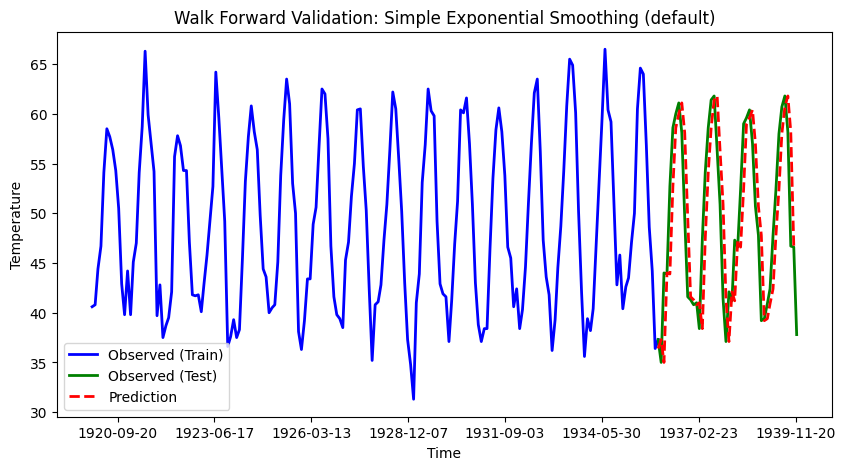

RMSE: 5.14


np.float64(5.143604473515007)

In [117]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

history = list(train['Temperature'])
preds = []

for t in range(len(test)):
    model = SimpleExpSmoothing(history).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Temperature'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Temperature',
    title="Walk Forward Validation: Simple Exponential Smoothing (default)",
    ylabel="Temperature"
)

El modelo de SES presenta un RMSE de 5.14, el cual es bastante bueno en comparación al modelo anterior. Observando la gráfica, nos damos cuenta que igual existe un ligero "desfase" por falta de componente estacional, sin embargo en este caso se mantiene más apegado ya que el modelo no es tan "brusco" con los datos nuevos. Podemos intentar buscar mejores parámetros utilizango Gridsearch

Best alpha: 1.00 with RMSE: 5.14


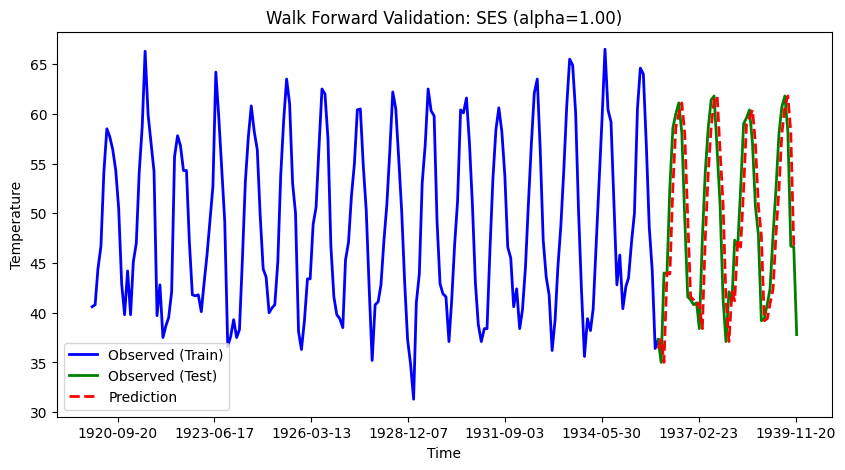

RMSE: 5.14


np.float64(5.143604443060009)

In [128]:
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error

alphas = np.linspace(0.01, 1.0, 20)
best_rmse = float('inf')
best_alpha = None
best_preds = None

for alpha in alphas:
    history = list(train['Temperature'])
    preds = []
    for t in range(len(test)):
        model = SimpleExpSmoothing(history).fit(smoothing_level=alpha, optimized=False)
        pred = model.forecast(1)[0]
        preds.append(pred)
        history.append(test['Temperature'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Temperature'], preds))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
        best_preds = preds

print(f"Best alpha: {best_alpha:.2f} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Temperature',
    title=f"Walk Forward Validation: SES (alpha={best_alpha:.2f})",
    ylabel="Temperature"
)

En este caso, exploramos diferentes valores dónde los más apropiados fueron los iniciales. Esto nos indica que un alfa demasiado alto puede hacer que cambie demasiado rápido y sufra los mismos problemas que Moving Average, mientras que un alfa demasiado bajo puede que no encuentre una relación lo suficientemente adecuada para el conjunto de datos.

### 4. Holt Winters

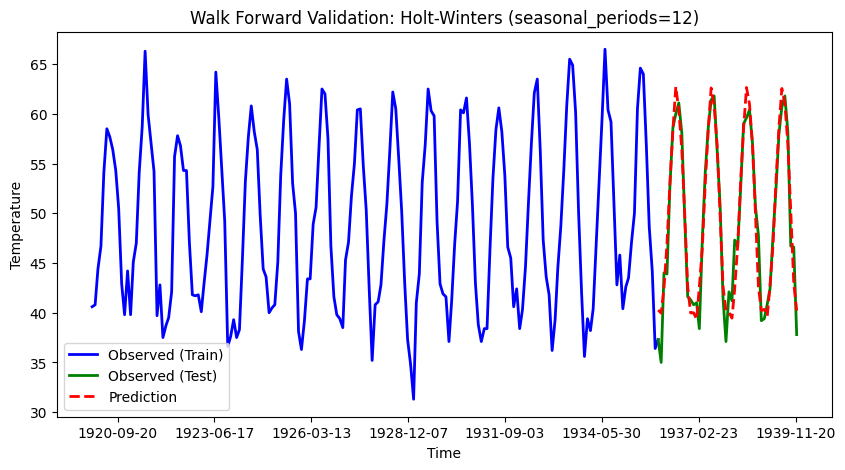

RMSE: 2.08


np.float64(2.084366625436126)

In [130]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

seasonal_periods = 12

history = list(train['Temperature'])
preds = []

for t in range(len(test)):
    model = ExponentialSmoothing(
        history,
        trend='add',
        seasonal='add',
        seasonal_periods=seasonal_periods
    ).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Temperature'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Temperature',
    title=f"Walk Forward Validation: Holt-Winters (seasonal_periods={seasonal_periods})",
    ylabel="Temperature"
)

Con un RMSE de 2.08, este modelo es el que mejor rendimiento ha tenido hasta el momento. Esto es gracias a su componente estacional que lo permite evitar los "desfases" que vimos en los modelos anteriores. En cuanto a parámetros, el más influencial es seasonal_periods que lógicamente debería ser 12 ya que las temperaturas en un mes del año tienden a repetirse o por lo menos parecerse. El rendimiento del modelo aprueba que fue una buena decisión, pero todavía podemos realizar una búsqueda de diferentes parámetros de smoothing.

...........................

Best params: smoothing_level=0.2, smoothing_trend=0.2, smoothing_seasonal=0.2, RMSE=2.45


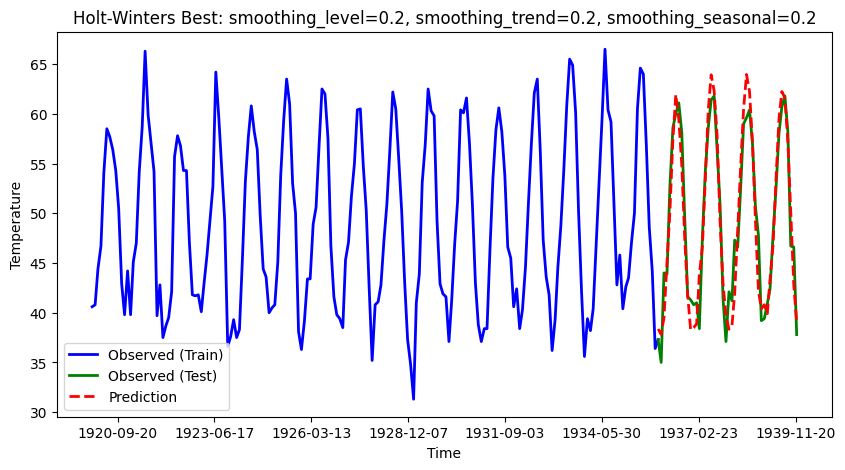

RMSE: 2.45


np.float64(2.4521757415328094)

In [133]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

seasonal_periods = 12
trend = 'add'
seasonal = 'add'

smoothing_level_options = [0.2, 0.5, 0.8]
smoothing_trend_options = [0.2, 0.5, 0.8]
smoothing_seasonal_options = [0.2, 0.5, 0.8]

best_rmse = float('inf')
best_params = None
best_preds = None

for smoothing_level in smoothing_level_options:
    for smoothing_trend in smoothing_trend_options:
        for smoothing_seasonal in smoothing_seasonal_options:
            history = list(train['Temperature'])
            preds = []
            try:
                for t in range(len(test)):
                    model = ExponentialSmoothing(
                        history,
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=seasonal_periods
                    ).fit(
                        smoothing_level=smoothing_level,
                        smoothing_trend=smoothing_trend,
                        smoothing_seasonal=smoothing_seasonal,
                        optimized=False
                    )
                    pred = model.forecast(1)[0]
                    preds.append(pred)
                    history.append(test['Temperature'].iloc[t])
                rmse = np.sqrt(mean_squared_error(test['Temperature'], preds))
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (smoothing_level, smoothing_trend, smoothing_seasonal)
                    best_preds = preds
                print('.', end='', flush=True)
            except Exception:
                print('x', end='', flush=True)

print(f"\n\nBest params: smoothing_level={best_params[0]}, smoothing_trend={best_params[1]}, smoothing_seasonal={best_params[2]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Temperature',
    title=f"Holt-Winters Best: smoothing_level={best_params[0]}, smoothing_trend={best_params[1]}, smoothing_seasonal={best_params[2]}",
    ylabel="Temperature"
)

En este caso el rendimiento fue peor, por lo que podemos concluir que los parámetros de smoothing iniciales son apropiados para el dataset.

### 5. SARIMA

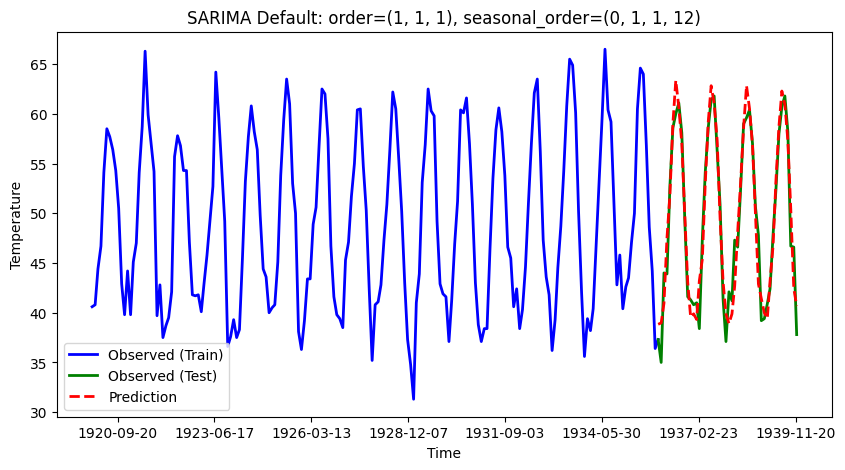

RMSE: 2.21


np.float64(2.2057661340223853)

In [134]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 1, 1)
seasonal_order = (0, 1, 1, 12)

history = list(train['Temperature'])
preds = []

for t in range(len(test)):
    model = SARIMAX(
        history,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Temperature'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Temperature',
    title=f"SARIMA Default: order={order}, seasonal_order={seasonal_order}",
    ylabel="Temperature"
)

Con un RMSE de 2.21, SARIMA se encuentra cerca del modelo Winter Holts en cuanto a rendimiento. De manera similar, esto se debe al componente estacional que implementa este modelo. Podemos explorar diferentes parámetros para intentar encontrar un rendimiento más alto, en este caso estamos buscando encontrar relaciones más complicadas que Winter Holts no podría explicar.

................................................................
Best parameters:
order=(0, 0, 0), seasonal_order=(0, 1, 1, 12), RMSE=2.09


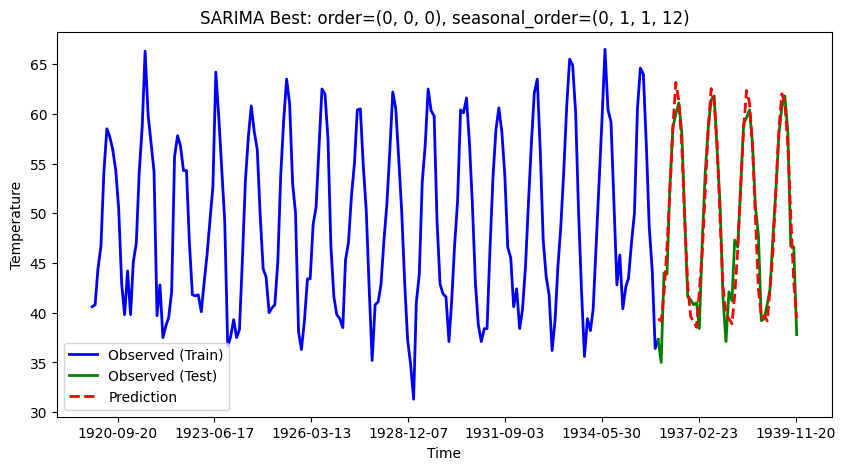

RMSE: 2.09


np.float64(2.085793998147804)

In [122]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import numpy as np
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = [12]

param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

best_rmse = float('inf')
best_params = None
best_preds = None

for idx, (p_, d_, q_, P_, D_, Q_, s_) in enumerate(param_combinations):
    history = list(train['Temperature'])
    preds = []
    try:
        for t in range(len(test)):
            model = SARIMAX(
                history,
                order=(p_, d_, q_),
                seasonal_order=(P_, D_, Q_, s_),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            pred = model.forecast(1)[0]
            preds.append(pred)
            history.append(test['Temperature'].iloc[t])
        rmse = np.sqrt(mean_squared_error(test['Temperature'], preds))
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = ((p_, d_, q_), (P_, D_, Q_, s_))
            best_preds = preds
        print('.', end='', flush=True)
    except Exception:
        print('x', end='', flush=True)

print("\nBest parameters:")
print(f"order={best_params[0]}, seasonal_order={best_params[1]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Temperature',
    title=f"SARIMA Best: order={best_params[0]}, seasonal_order={best_params[1]}",
    ylabel="Temperature"
)

Luego de un gridsearch, tenemos un RMSE de 2.09. Este es un rendimiento bastante similar a Winter Holts. Esto nos indica que no existen relaciones más complicadas que no se puedan explicar con Winter Holts, y posiblemente sea el modelo más apropiado para este dataset.

### 6. Prophet

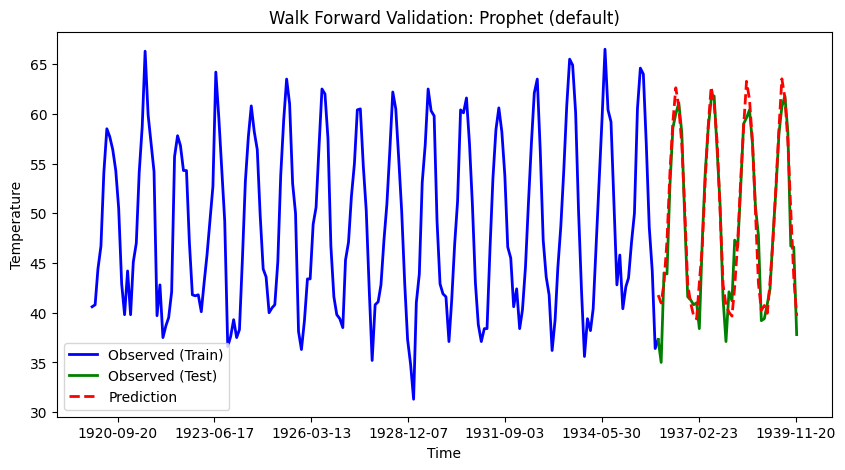

RMSE: 2.20


np.float64(2.2036300761803984)

In [ ]:
import pandas as pd
from prophet import Prophet

if not pd.api.types.is_datetime64_any_dtype(train.index):
    train = train.copy()
    test = test.copy()
    train['Month'] = pd.date_range(start='1920-01', periods=len(train), freq='MS')
    test['Month'] = pd.date_range(start=train['Month'].iloc[-1] + pd.offsets.MonthBegin(1), periods=len(test), freq='MS')
    train.set_index('Month', inplace=True)
    test.set_index('Month', inplace=True)

train_prophet = train.reset_index().rename(columns={train.index.name or 'index': 'ds', 'Temperature': 'y'})
test_prophet = test.reset_index().rename(columns={test.index.name or 'index': 'ds', 'Temperature': 'y'})

train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

history = train_prophet.copy()
preds = []

for t in range(len(test)):
    m = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
    m.fit(history)
    future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
    forecast = m.predict(future)
    pred = forecast['yhat'].values[0]
    preds.append(pred)
    history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)

plot_walk_forward(
    train, test, preds, col='Temperature',
    title="Walk Forward Validation: Prophet (default)",
    ylabel="Temperature"
)

El modelo inicial de Prophet es bastante parecido a los anteriores, debido al factor estacional se ajusta bastante bien a la información. Adicionalmente, en comparación al primer dataset, este dataset tiene un conjunto de datos más extenso. Esto apoya el alto rendimiento de Prophet en datasets más grandes, en comparación a datasets más reducidos. Podemos realizar un Gridsearch explorando los diferentes parámetros que nos ofrece Prophet.

........................

Best params: mode=additive, changepoint_prior_scale=0.01, seasonality_prior_scale=10.0, holidays_prior_scale=1.0, RMSE=2.06


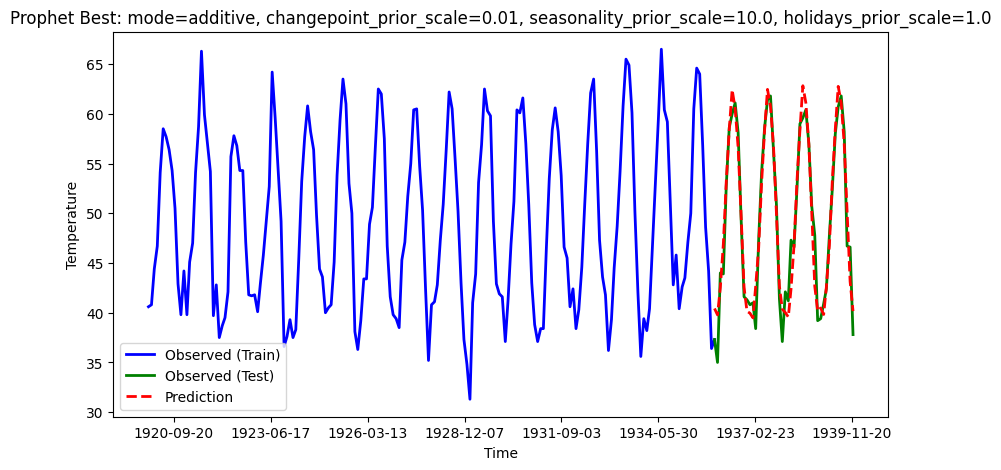

RMSE: 2.06


np.float64(2.063245850160289)

In [137]:
from prophet import Prophet
import numpy as np

seasonality_modes = ['additive', 'multiplicative']
changepoint_scales = [0.01, 0.1, 0.5]
seasonality_prior_scales = [1.0, 10.0]
holidays_prior_scales = [1.0, 10.0]

best_rmse = float('inf')
best_params = None
best_preds = None

for mode in seasonality_modes:
    for cps in changepoint_scales:
        for sps in seasonality_prior_scales:
            for hps in holidays_prior_scales:
                history = train_prophet.copy()
                preds = []
                try:
                    for t in range(len(test)):
                        m = Prophet(
                            yearly_seasonality=True,
                            daily_seasonality=False,
                            weekly_seasonality=False,
                            seasonality_mode=mode,
                            changepoint_prior_scale=cps,
                            seasonality_prior_scale=sps,
                            holidays_prior_scale=hps
                        )
                        m.fit(history)
                        future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
                        forecast = m.predict(future)
                        pred = forecast['yhat'].values[0]
                        preds.append(pred)
                        history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)
                    rmse = np.sqrt(mean_squared_error(test['Temperature'], preds))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = (mode, cps, sps, hps)
                        best_preds = preds
                    print('.', end='', flush=True)
                except Exception:
                    print('x', end='', flush=True)

print(f"\n\nBest params: mode={best_params[0]}, changepoint_prior_scale={best_params[1]}, seasonality_prior_scale={best_params[2]}, holidays_prior_scale={best_params[3]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Temperature',
    title=f"Prophet Best: mode={best_params[0]}, changepoint_prior_scale={best_params[1]}, seasonality_prior_scale={best_params[2]}, holidays_prior_scale={best_params[3]}",
    ylabel="Temperature"
)

Obteniendo un RMSE de 2.06, Prophet es el modelo más adecuado para este dataset. A pesar que no haya una diferencia tan grande entre estos valores en comparación a los demás modelos, debemos recordar que la escala en la que estamos trabajando es relativamente pequeña y se valora más la precisión.

### 7. Comparación y Evaluación

En el caso de "monthly-mean-temps.csv", el mejor modelo fue Prophet luego de realizar un Gridsearch. Justo como detallamos en las predicciones, los modelos con un factor estacional probaron ser superiores a los demás cómo Holt-Winters y ARIMA que estuvieron cerca de Prophet. El problema con los modelos sin factor estacional es que se "desfasaban", en el sentido que los promedios al basarse en meses anteriores se quedaban "una temporada atrás" y realizaban predicciones incorrectas. Además, tuvimos razón al predecir un mejor rendimiento de Prophet en este caso en comparación a shampoo.csv.

## monthly-car-sales.csv

### 1. Análisis Exploratorio

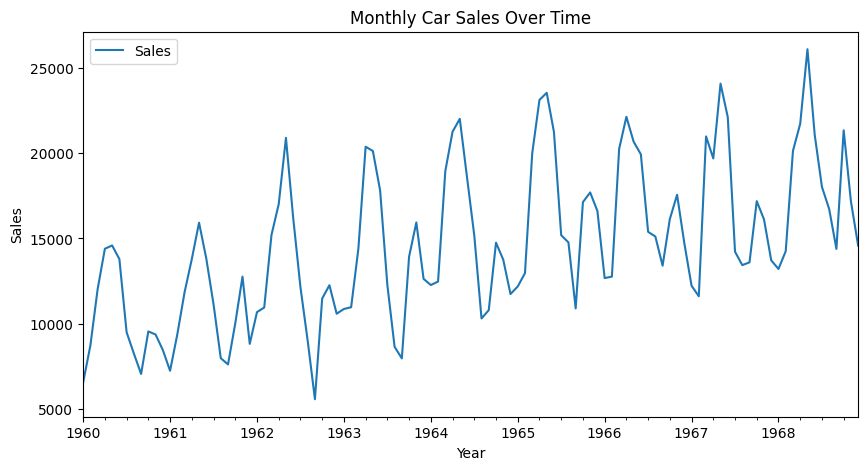

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = 'monthly-car-sales.csv'
df = pd.read_csv(f'datasets/{filename}', index_col='Month', parse_dates=True)
df.index.freq = 'MS'

train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

df.plot(figsize=(10, 5), label='Sales')
plt.title("Monthly Car Sales Over Time")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend()
plt.show()

Analizando este conjunto de datos, parece existir una tendencia general dónde cada año se venden más carros. Adicionalmente, parece que la venta de carros se ve afectada significativamente por la temporada. Cada año parece tener picos muy altos y luego declinar significativamente. Podemos realizar las siguientes predicciones:

- Nuevamente los modelos con factor estacional probarán ser superiores
- Las relaciones parecen ser complicadas, por lo que ARIMA puede probar ser superior a Holt Winters

### 2. Promedios Móviles

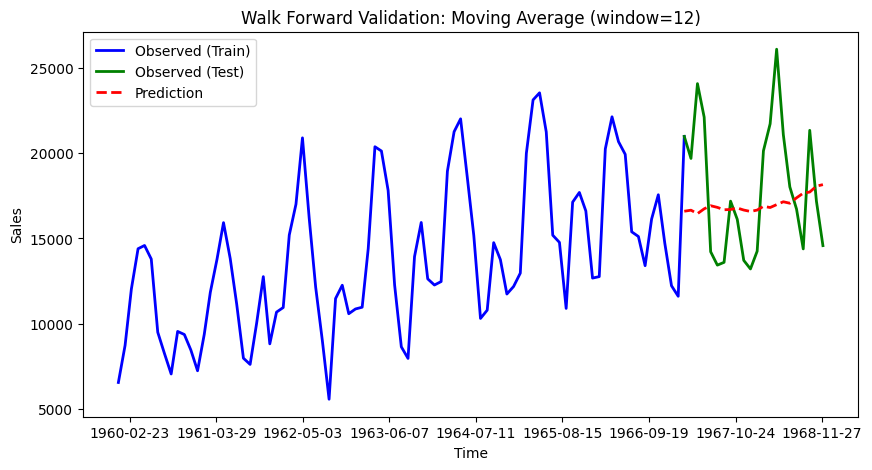

RMSE: 3945.59


np.float64(3945.586427229145)

In [141]:
window = 12
history = list(train['Sales'])
preds = []
for t in range(len(test)):
    if len(history) >= window:
        pred = np.mean(history[-window:])
    else:
        pred = np.mean(history)
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title=f"Walk Forward Validation: Moving Average (window={window})",
    ylabel="Sales"
)

Empezando con una ventana relativamente alta, obtuvimos un RMSe de 3945. Tomando en cuenta la magnitud de los datos con los que estamos trabajando, parece tener un rendimiento bastante pobre. Podemos predecir que al tener ventanas más pequeñas, el modelo tendrá un rendimiento más alto por lo que realizaremos un Gridsearch.

Best window: 12 with RMSE: 3945.59


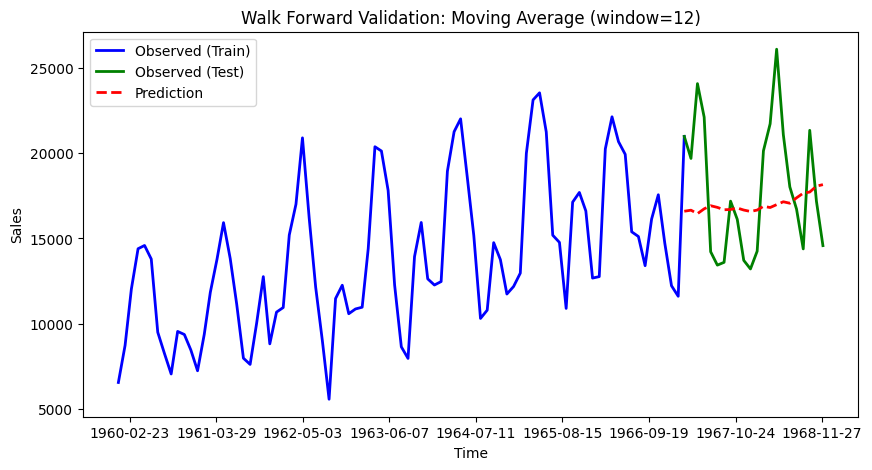

RMSE: 3945.59


np.float64(3945.586427229145)

In [142]:
from sklearn.metrics import mean_squared_error

best_rmse = float('inf')
best_window = None
best_preds = None

for window in range(2, 13):
    history = list(train['Sales'])
    preds = []
    for t in range(len(test)):
        if len(history) >= window:
            pred = np.mean(history[-window:])
        else:
            pred = np.mean(history)
        preds.append(pred)
        history.append(test['Sales'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
    if rmse < best_rmse:
        best_rmse = rmse
        best_window = window
        best_preds = preds

print(f"Best window: {best_window} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Walk Forward Validation: Moving Average (window={best_window})",
    ylabel="Sales"
)

Luego de realizar un Gridsearch, rápidamente identificamos que nuestra predicción fue completamente errónea. Esto puede deberse a la alta variabilidad en el número de ventas de carros. En este caso, puede que una ventana más pequeña simplemente genere valores que no se acercan para nada al del siguiente mes. En vez de eso, un modelo con una ventana más grande puede captar trends generales de mejor manera.

### 3. Alisamiento Exponencial

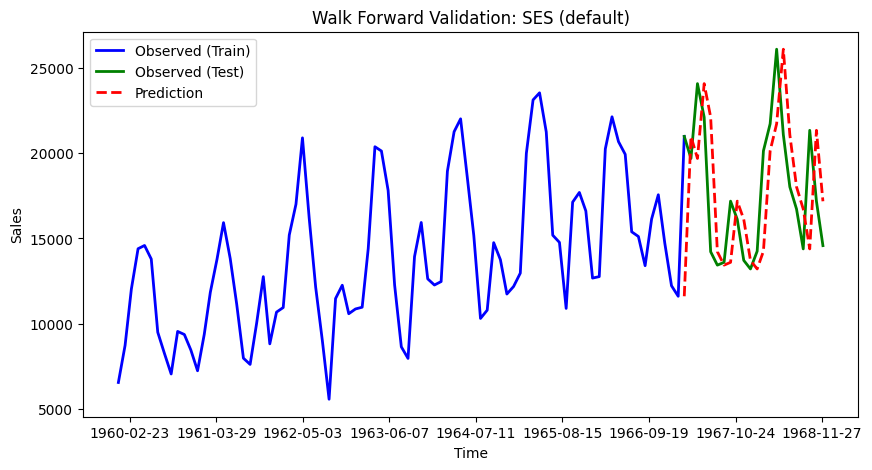

RMSE: 4086.14


np.float64(4086.1378872528458)

In [143]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

history = list(train['Sales'])
preds = []
for t in range(len(test)):
    model = SimpleExpSmoothing(history).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title="Walk Forward Validation: SES (default)",
    ylabel="Sales"
)

Con un RMSe de 4086, el rendimiento del modelo fue bastante pobre. Aquí de manera similar al dataset anterior, podemos identificar un "desfase" en las predicciones al no tener un factor estacional. Adicionalmente, podemos ver como el "approach" del modelo cambia significativamente en comparación a Moving Average, dónde aquí si se busca predecir valores exactos y no necesariamente un trend.

Best alpha: 0.90 with RMSE: 4077.11


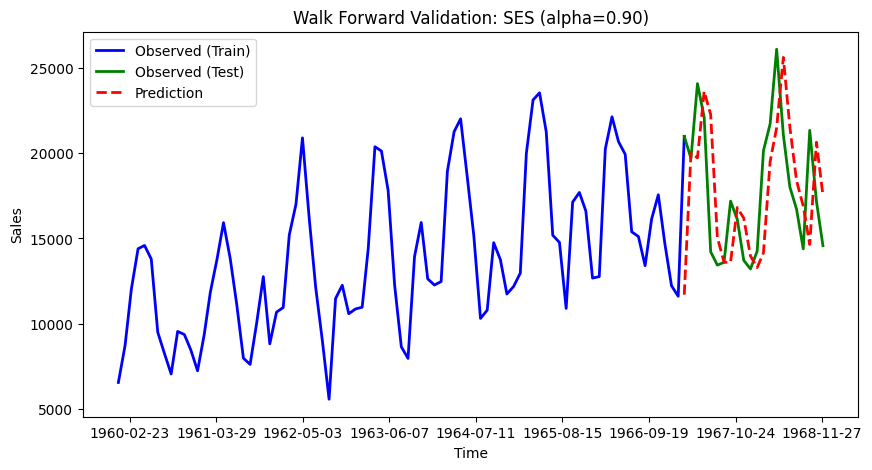

RMSE: 4077.11


np.float64(4077.113954568528)

In [144]:
alphas = np.linspace(0.01, 1.0, 20)
best_rmse = float('inf')
best_alpha = None
best_preds = None

for alpha in alphas:
    history = list(train['Sales'])
    preds = []
    for t in range(len(test)):
        model = SimpleExpSmoothing(history).fit(smoothing_level=alpha, optimized=False)
        pred = model.forecast(1)[0]
        preds.append(pred)
        history.append(test['Sales'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
        best_preds = preds

print(f"Best alpha: {best_alpha:.2f} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Walk Forward Validation: SES (alpha={best_alpha:.2f})",
    ylabel="Sales"
)

Luego de realizar un gridsearch, los problemas persisten. El desfase del modelo resulta en imprecisiones marcadas y no logra realizar predicciones adecuadas con un RMSE de 4077.

### 4. Holt Winters

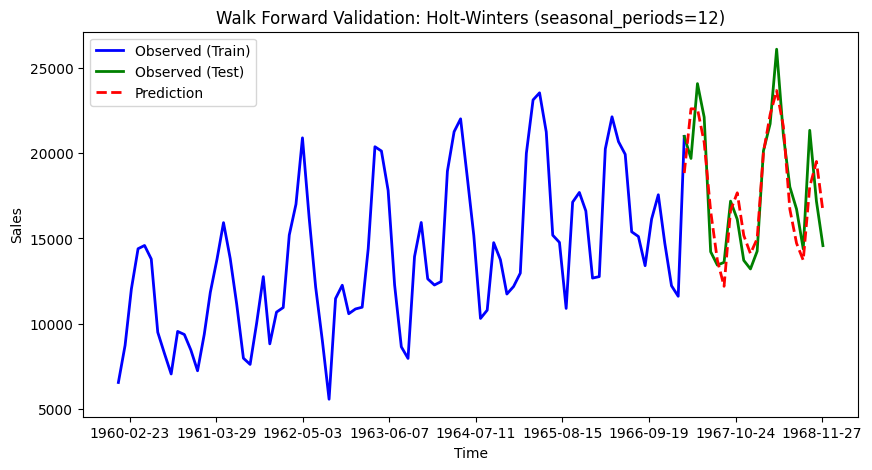

RMSE: 1712.91


np.float64(1712.9068463721003)

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

seasonal_periods = 12
history = list(train['Sales'])
preds = []
for t in range(len(test)):
    model = ExponentialSmoothing(
        history,
        trend='add',
        seasonal='add',
        seasonal_periods=seasonal_periods
    ).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title=f"Walk Forward Validation: Holt-Winters (seasonal_periods={seasonal_periods})",
    ylabel="Sales"
)

Al ser el primer modelo con factor estacional, su RMSE de 1712 confirma la hipótesis sobre el rendimiento de este tipo de modelos. En la gráfica podemos observas cómo las predicciones se encuentran "al día" sin desfase alguno. La única "debilidad" del modelo son los picos altos, por lo que podemos buscar resolver este problema por medio de un Gridsearch.

...........................

Best params: smoothing_level=0.2, smoothing_trend=0.2, smoothing_seasonal=0.5, RMSE=1709.71


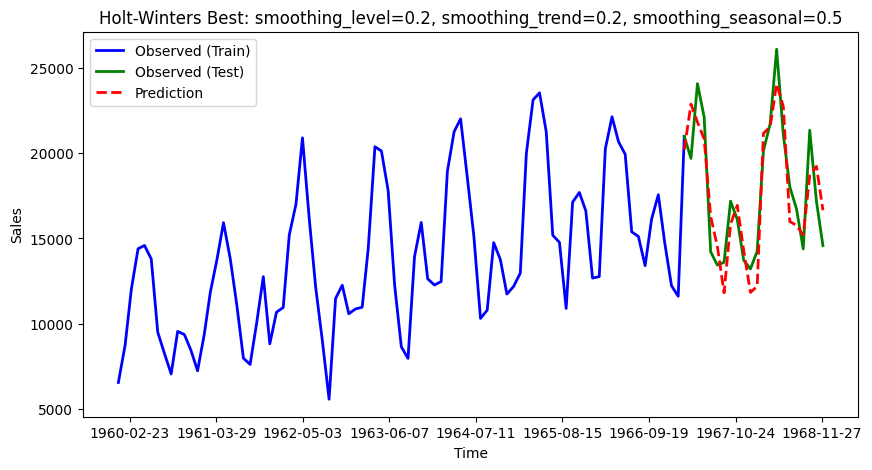

RMSE: 1709.71


np.float64(1709.706527931263)

In [147]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

seasonal_periods = 12
trend = 'add'
seasonal = 'add'

smoothing_level_options = [0.2, 0.5, 0.8]
smoothing_trend_options = [0.2, 0.5, 0.8]
smoothing_seasonal_options = [0.2, 0.5, 0.8]

best_rmse = float('inf')
best_params = None
best_preds = None

for smoothing_level in smoothing_level_options:
    for smoothing_trend in smoothing_trend_options:
        for smoothing_seasonal in smoothing_seasonal_options:
            history = list(train['Sales'])
            preds = []
            try:
                for t in range(len(test)):
                    model = ExponentialSmoothing(
                        history,
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=seasonal_periods
                    ).fit(
                        smoothing_level=smoothing_level,
                        smoothing_trend=smoothing_trend,
                        smoothing_seasonal=smoothing_seasonal,
                        optimized=False
                    )
                    pred = model.forecast(1)[0]
                    preds.append(pred)
                    history.append(test['Sales'].iloc[t])
                rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (smoothing_level, smoothing_trend, smoothing_seasonal)
                    best_preds = preds
                print('.', end='', flush=True)
            except Exception:
                print('x', end='', flush=True)

print(f"\n\nBest params: smoothing_level={best_params[0]}, smoothing_trend={best_params[1]}, smoothing_seasonal={best_params[2]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Holt-Winters Best: smoothing_level={best_params[0]}, smoothing_trend={best_params[1]}, smoothing_seasonal={best_params[2]}",
    ylabel="Sales"
)

En este caso, logramos ver una ligera mejora pero no un cambio drástico. Luego del Gridsearch, encontramos parámetros más adecuados pero realmente no hubo una diferencia significativa. Hasta el momento, Holt Winters es el algoritmo más adecuado.

### 5. SARIMA

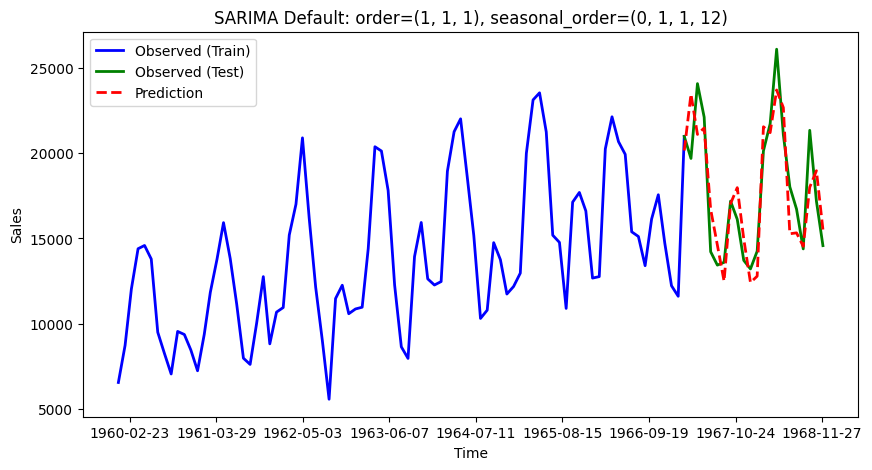

RMSE: 1860.23


np.float64(1860.2326120583562)

In [148]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 1, 1)
seasonal_order = (0, 1, 1, 12)

history = list(train['Sales'])
preds = []
for t in range(len(test)):
    model = SARIMAX(
        history,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title=f"SARIMA Default: order={order}, seasonal_order={seasonal_order}",
    ylabel="Sales"
)

Con un RMSe de 1860, este modelo tuvo un rendimiento ligeramente peor que Holt Winters. En este caso, puede que los patrones presentes en el dataset sean más simples y se puedan explicar simplemente con un trend y estacionalidad. Esto comprueba que nuestra hipótesis era errónea, y realmente los patrones no son tan erráticos como pueden parecer a primera vista. Sin embargo, vamos a realizar un Gridsearch para poder confirmar esto.

................................................................
Best params: order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), RMSE=1789.93


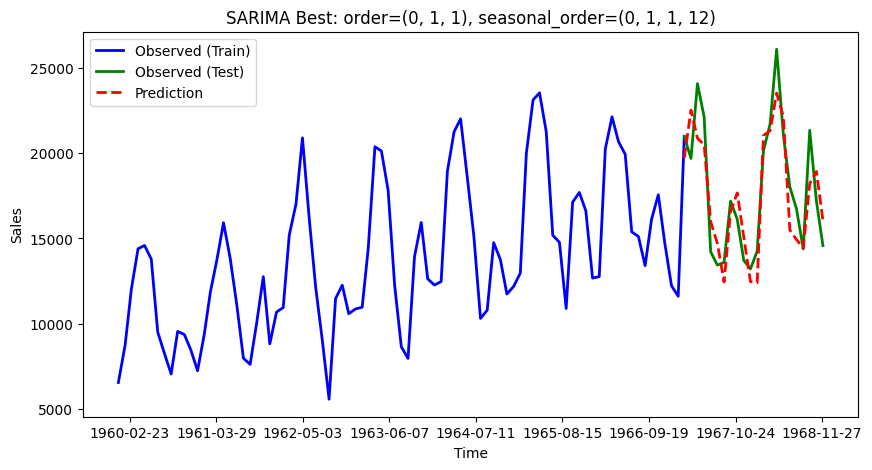

RMSE: 1789.93


np.float64(1789.9267029881933)

In [149]:
import itertools
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = [12]

param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

best_rmse = float('inf')
best_params = None
best_preds = None

for idx, (p_, d_, q_, P_, D_, Q_, s_) in enumerate(param_combinations):
    history = list(train['Sales'])
    preds = []
    try:
        for t in range(len(test)):
            model = SARIMAX(
                history,
                order=(p_, d_, q_),
                seasonal_order=(P_, D_, Q_, s_),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            pred = model.forecast(1)[0]
            preds.append(pred)
            history.append(test['Sales'].iloc[t])
        rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = ((p_, d_, q_), (P_, D_, Q_, s_))
            best_preds = preds
        print('.', end='', flush=True)
    except Exception:
        print('x', end='', flush=True)

print(f"\nBest params: order={best_params[0]}, seasonal_order={best_params[1]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"SARIMA Best: order={best_params[0]}, seasonal_order={best_params[1]}",
    ylabel="Sales"
)

Luego de un Gridsearch, Holt Winters sigue siendo el mejor modelo hasta el momento. En este caso, obtuvimos una ligera mejora en el RMSE con 1789 pero la gráfica parece todavía no captar patrones tan precisamente.

### 6. Prophet

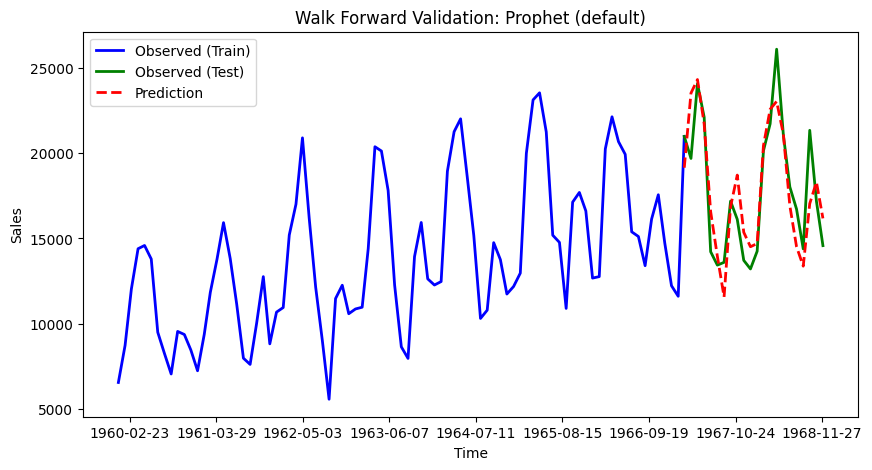

RMSE: 1898.41


np.float64(1898.4125780746372)

In [153]:
from prophet import Prophet

if not pd.api.types.is_datetime64_any_dtype(train.index):
    train = train.copy()
    test = test.copy()
    train['Month'] = pd.date_range(start='1960-01', periods=len(train), freq='MS')
    test['Month'] = pd.date_range(start=train['Month'].iloc[-1] + pd.offsets.MonthBegin(1), periods=len(test), freq='MS')
    train.set_index('Month', inplace=True)
    test.set_index('Month', inplace=True)

train_prophet = train.reset_index().rename(columns={train.index.name or 'index': 'ds', 'Sales': 'y'})
test_prophet = test.reset_index().rename(columns={test.index.name or 'index': 'ds', 'Sales': 'y'})
train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

history = train_prophet.copy()
preds = []
for t in range(len(test)):
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(history)
    future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
    forecast = m.predict(future)
    pred = forecast['yhat'].values[0]
    preds.append(pred)
    history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)

plot_walk_forward(
    train, test, preds, col='Sales',
    title="Walk Forward Validation: Prophet (default)",
    ylabel="Sales"
)

Con un RMSE de 1898, Prophet se queda atrás de Holt Winters todavía. Parece captar las tendencias bastante bien, pero sigue teniendo problemas al captar la tendencia general de incremento. Por ejemplo, los mínimos y máximos tienden a tener predicciones por debajo. Esto puede indicar que un simple trend explica la relación de mejor manera. Para afirmar esto, vamos a realizar un Gridsearch y buscar diferentes parámetros.

............

Best params: mode=additive, changepoint_prior_scale=0.1, seasonality_prior_scale=10.0, RMSE=1907.15


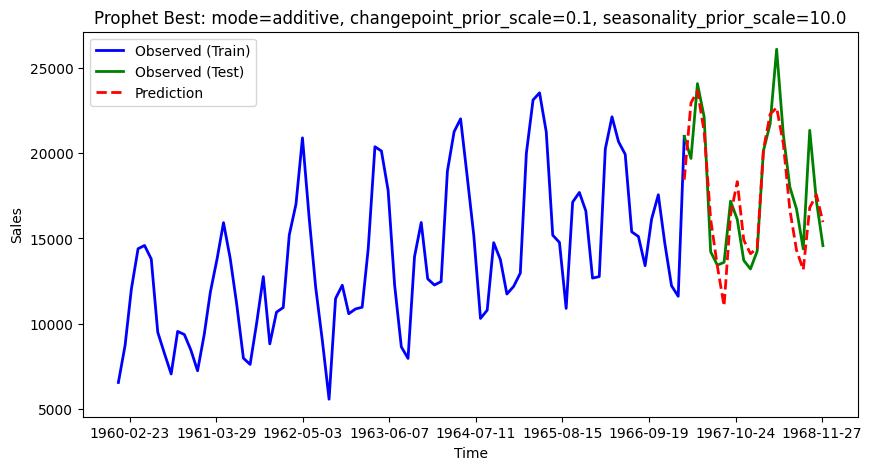

RMSE: 1907.15


np.float64(1907.1537555557825)

In [154]:
from prophet import Prophet
import numpy as np

# Ensure index is datetime
if not pd.api.types.is_datetime64_any_dtype(train.index):
    train = train.copy()
    test = test.copy()
    train['Month'] = pd.date_range(start='1960-01', periods=len(train), freq='MS')
    test['Month'] = pd.date_range(start=train['Month'].iloc[-1] + pd.offsets.MonthBegin(1), periods=len(test), freq='MS')
    train.set_index('Month', inplace=True)
    test.set_index('Month', inplace=True)

train_prophet = train.reset_index().rename(columns={train.index.name or 'index': 'ds', 'Sales': 'y'})
test_prophet = test.reset_index().rename(columns={test.index.name or 'index': 'ds', 'Sales': 'y'})
train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

seasonality_modes = ['additive', 'multiplicative']
changepoint_scales = [0.01, 0.1, 0.5]
seasonality_prior_scales = [1.0, 10.0]

best_rmse = float('inf')
best_params = None
best_preds = None

for mode in seasonality_modes:
    for cps in changepoint_scales:
        for sps in seasonality_prior_scales:
            history = train_prophet.copy()
            preds = []
            try:
                for t in range(len(test)):
                    m = Prophet(
                        yearly_seasonality=True,
                        weekly_seasonality=False,
                        daily_seasonality=False,
                        seasonality_mode=mode,
                        changepoint_prior_scale=cps,
                        seasonality_prior_scale=sps
                    )
                    m.fit(history)
                    future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
                    forecast = m.predict(future)
                    pred = forecast['yhat'].values[0]
                    preds.append(pred)
                    history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)
                rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (mode, cps, sps)
                    best_preds = preds
                print('.', end='', flush=True)
            except Exception:
                print('x', end='', flush=True)

print(f"\n\nBest params: mode={best_params[0]}, changepoint_prior_scale={best_params[1]}, seasonality_prior_scale={best_params[2]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Prophet Best: mode={best_params[0]}, changepoint_prior_scale={best_params[1]}, seasonality_prior_scale={best_params[2]}",
    ylabel="Sales"
)

En este caso, al explorar diferentes valores encontramos un rendimiento sumamente similar. Podemos concluir que Prophet puede ser un modelo muy complejo para este problema y la inclusión de diferentes patrones puede llevar a overfitting.

### 7. Comparación y Evaluación

En este caso, las predicciones realizadas no fueron realmente precisas. A simple vista, el conjunto de datos parecía tener relaciones más complicadas cuando realmente se explican por un trend y estacionalidad. Lo que podemos asegurar, fue el rendimiento superior de los modelos con factor estacionalidad y los mismos "desfases" vistos en el dataset anterior. El mejor modelo fue Holt Winters, con un RMSE de 1709; seguido de ARIMA con 1789. Al haber tenido un "mejor ojo" para analizar la gráfica inicial, las predicciones pudieron haber sido más precisas.

## daily-total-female-births.csv

### Análisis exploratorio

           Births
count  365.000000
mean    41.980822
std      7.348257
min     23.000000
25%     37.000000
50%     42.000000
75%     46.000000
max     73.000000


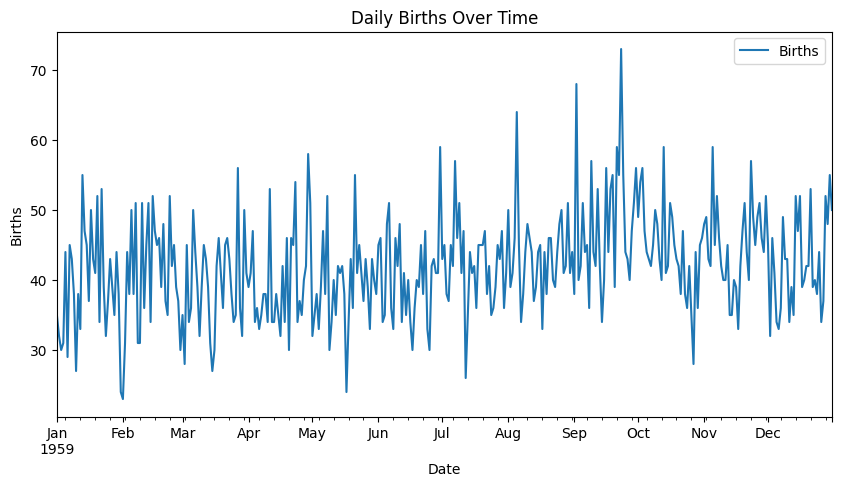

In [ ]:
filename = 'daily-total-female-births.csv'
df = pd.read_csv(f'datasets/{filename}', index_col='Date', parse_dates=True)
df.index.freq = 'D'

train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

df.plot(figsize=(10, 5), label='Births')
plt.title("Daily Births Over Time")
plt.xlabel("Date")
plt.ylabel("Births")
plt.legend()
plt.show()

### Promedios móviles

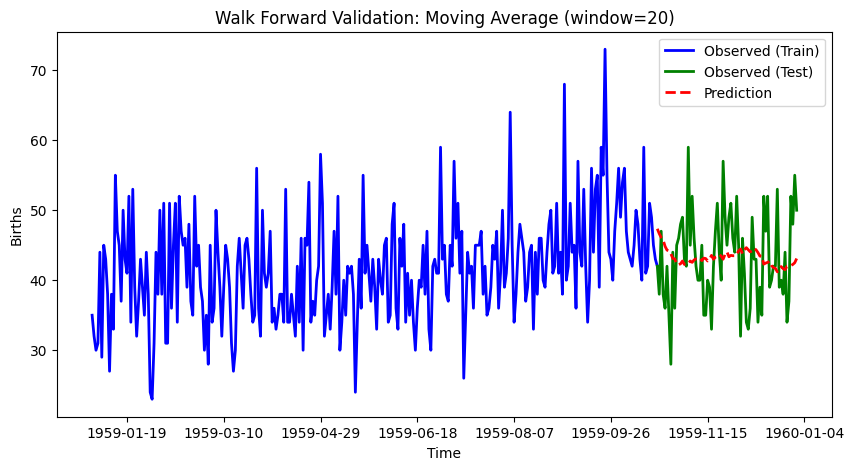

RMSE: 6.81


np.float64(6.809127134131593)

In [ ]:
window = 20
history = list(train['Births'])
preds = []
for t in range(len(test)):
    if len(history) >= window:
        pred = np.mean(history[-window:])
    else:
        pred = np.mean(history)
    preds.append(pred)
    history.append(test['Births'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Births',
    title=f"Walk Forward Validation: Moving Average (window={window})",
    ylabel="Births"
)

Best window: 5 with RMSE: 6.71


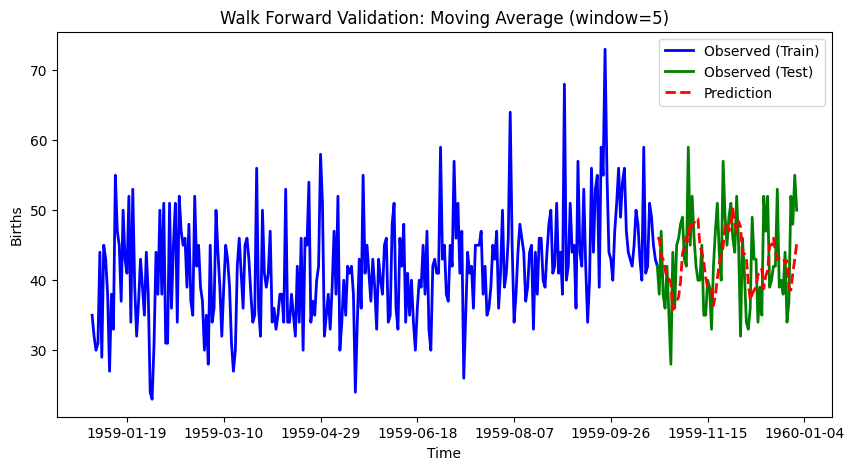

RMSE: 6.71


np.float64(6.710000714533575)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

best_rmse = float('inf')
best_window = None
best_preds = None

for window in range(5, 50, 5):
    history = list(train['Births'])
    preds = []
    for t in range(len(test)):
        if len(history) >= window:
            pred = np.mean(history[-window:])
        else:
            pred = np.mean(history)
        preds.append(pred)
        history.append(test['Births'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Births'], preds))
    if rmse < best_rmse:
        best_rmse = rmse
        best_window = window
        best_preds = preds

print(f"Best window: {best_window} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Births',
    title=f"Walk Forward Validation: Moving Average (window={best_window})",
    ylabel="Births"
)

### Alisamiento exponencial

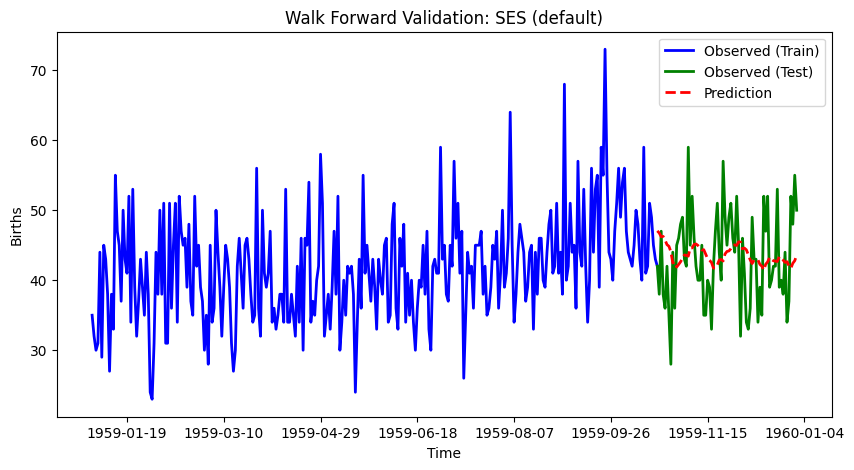

RMSE: 6.77


np.float64(6.7728993475604735)

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

history = list(train['Births'])
preds = []
for t in range(len(test)):
    model = SimpleExpSmoothing(history).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Births'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Births',
    title="Walk Forward Validation: SES (default)",
    ylabel="Births"
)

Best alpha: 0.01 with RMSE: 6.46


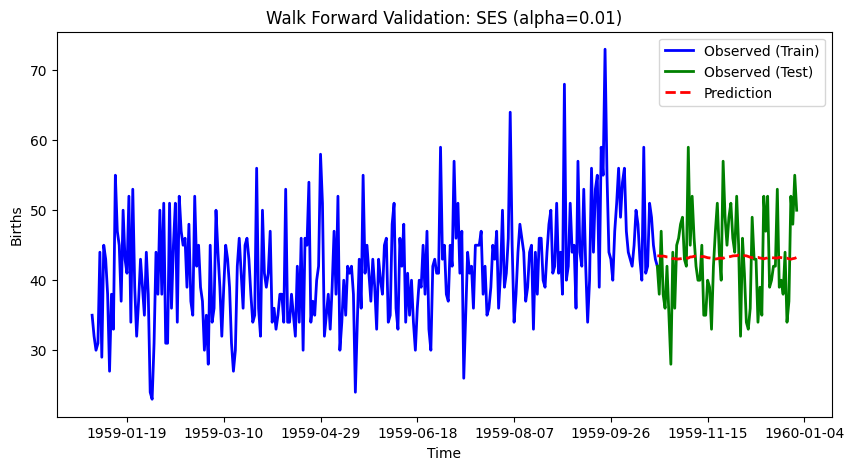

RMSE: 6.46


np.float64(6.463403022876727)

In [ ]:
alphas = np.linspace(0.01, 1.0, 20)
best_rmse = float('inf')
best_alpha = None
best_preds = None

for alpha in alphas:
    history = list(train['Births'])
    preds = []
    for t in range(len(test)):
        model = SimpleExpSmoothing(history).fit(smoothing_level=alpha, optimized=False)
        pred = model.forecast(1)[0]
        preds.append(pred)
        history.append(test['Births'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Births'], preds))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
        best_preds = preds

print(f"Best alpha: {best_alpha:.2f} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Births',
    title=f"Walk Forward Validation: SES (alpha={best_alpha:.2f})",
    ylabel="Births"
)

### Holt winter

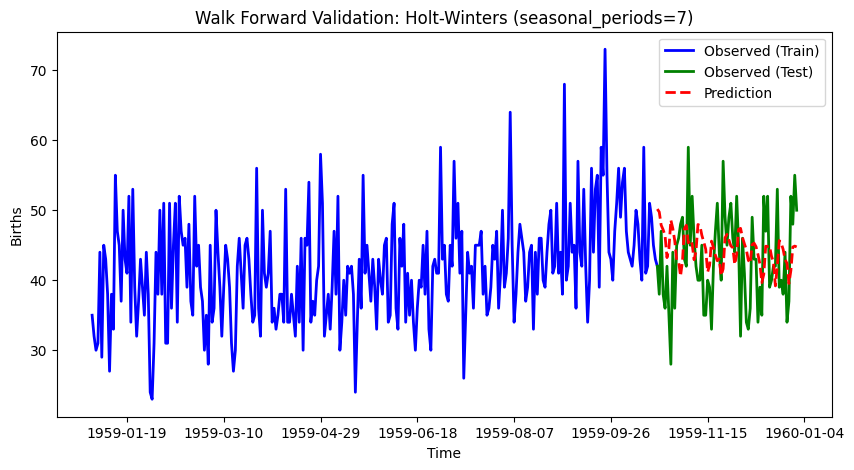

RMSE: 7.25


np.float64(7.253876914013144)

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

seasonal_periods = 7  # Weekly seasonality for daily data
history = list(train['Births'])
preds = []
for t in range(len(test)):
    model = ExponentialSmoothing(
        history,
        trend='add',
        seasonal='add',
        seasonal_periods=seasonal_periods
    ).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Births'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Births',
    title=f"Walk Forward Validation: Holt-Winters (seasonal_periods={seasonal_periods})",
    ylabel="Births"
)

Best params: trend=add, seasonal=None, seasonal_periods=7, RMSE=6.94


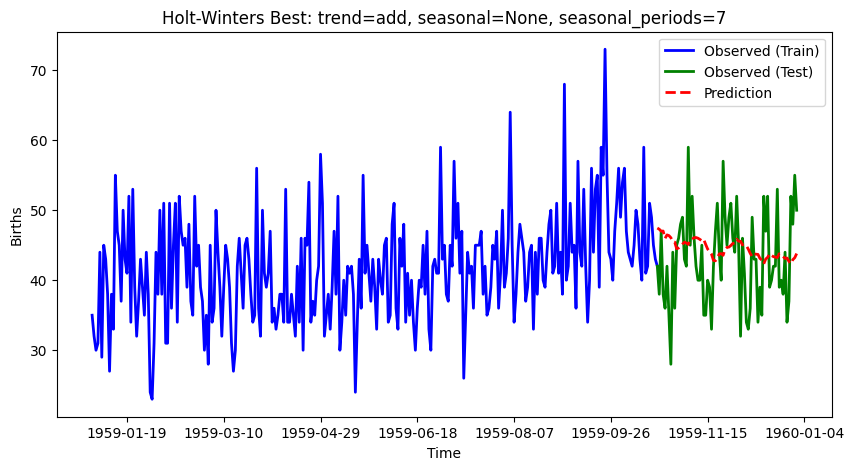

RMSE: 6.94


np.float64(6.9392319406660805)

In [ ]:
trend_options = ['add', None]
seasonal_options = ['add', None]
seasonal_periods_options = [7, 14]

best_rmse = float('inf')
best_params = None
best_preds = None

for trend in trend_options:
    for seasonal in seasonal_options:
        if trend is None and seasonal is None:
            continue
        for seasonal_periods in seasonal_periods_options:
            history = list(train['Births'])
            preds = []
            try:
                for t in range(len(test)):
                    model = ExponentialSmoothing(
                        history,
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=seasonal_periods
                    ).fit(optimized=True)
                    pred = model.forecast(1)[0]
                    preds.append(pred)
                    history.append(test['Births'].iloc[t])
                rmse = np.sqrt(mean_squared_error(test['Births'], preds))
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (trend, seasonal, seasonal_periods)
                    best_preds = preds
            except Exception as e:
                print(f"FAILED: trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods} ({e})")

print(f"Best params: trend={best_params[0]}, seasonal={best_params[1]}, seasonal_periods={best_params[2]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Births',
    title=f"Holt-Winters Best: trend={best_params[0]}, seasonal={best_params[1]}, seasonal_periods={best_params[2]}",
    ylabel="Births"
)

### SARIMA

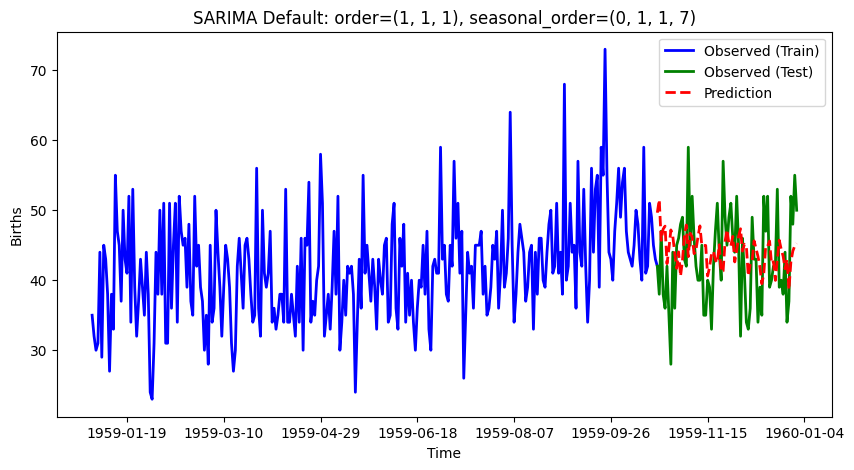

RMSE: 7.13


np.float64(7.134101381959051)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 1, 1)
seasonal_order = (0, 1, 1, 7)

history = list(train['Births'])
preds = []
for t in range(len(test)):
    model = SARIMAX(
        history,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Births'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Births',
    title=f"SARIMA Default: order={order}, seasonal_order={seasonal_order}",
    ylabel="Births"
)

In [ ]:
import itertools
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = [7]

param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

best_rmse = float('inf')
best_params = None
best_preds = None

for idx, (p_, d_, q_, P_, D_, Q_, s_) in enumerate(param_combinations):
    history = list(train['Births'])
    preds = []
    try:
        for t in range(len(test)):
            model = SARIMAX(
                history,
                order=(p_, d_, q_),
                seasonal_order=(P_, D_, Q_, s_),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            pred = model.forecast(1)[0]
            preds.append(pred)
            history.append(test['Births'].iloc[t])
        rmse = np.sqrt(mean_squared_error(test['Births'], preds))
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = ((p_, d_, q_), (P_, D_, Q_, s_))
            best_preds = preds
        print('.', end='', flush=True)
    except Exception:
        print('x', end='', flush=True)

print(f"\nBest params: order={best_params[0]}, seasonal_order={best_params[1]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Births',
    title=f"SARIMA Best: order={best_params[0]}, seasonal_order={best_params[1]}",
    ylabel="Births"
)

.......................................................

KeyboardInterrupt: 

### Prophet

In [ ]:
from prophet import Prophet

# Ensure index is datetime
if not pd.api.types.is_datetime64_any_dtype(train.index):
    train = train.copy()
    test = test.copy()
    train['Date'] = pd.date_range(start='1959-01-01', periods=len(train), freq='D')
    test['Date'] = pd.date_range(start=train['Date'].iloc[-1] + pd.offsets.Day(1), periods=len(test), freq='D')
    train.set_index('Date', inplace=True)
    test.set_index('Date', inplace=True)

train_prophet = train.reset_index().rename(columns={train.index.name or 'index': 'ds', 'Births': 'y'})
test_prophet = test.reset_index().rename(columns={test.index.name or 'index': 'ds', 'Births': 'y'})
train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

history = train_prophet.copy()
preds = []
for t in range(len(test)):
    m = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
    m.fit(history)
    future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
    forecast = m.predict(future)
    pred = forecast['yhat'].values[0]
    preds.append(pred)
    history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)

plot_walk_forward(
    train, test, preds, col='Births',
    title="Walk Forward Validation: Prophet (default)",
    ylabel="Births"
)

In [ ]:
seasonality_modes = ['additive', 'multiplicative']
changepoint_scales = [0.01, 0.1, 0.5]

best_rmse = float('inf')
best_params = None
best_preds = None

for mode in seasonality_modes:
    for cps in changepoint_scales:
        history = train_prophet.copy()
        preds = []
        try:
            for t in range(len(test)):
                m = Prophet(
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=False,
                    seasonality_mode=mode,
                    changepoint_prior_scale=cps
                )
                m.fit(history)
                future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
                forecast = m.predict(future)
                pred = forecast['yhat'].values[0]
                preds.append(pred)
                history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)
            rmse = np.sqrt(mean_squared_error(test['Births'], preds))
            print(f"mode={mode}, changepoint_prior_scale={cps}, RMSE={rmse:.2f}")
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (mode, cps)
                best_preds = preds
        except Exception as e:
            print(f"FAILED: mode={mode}, changepoint_prior_scale={cps} ({e})")

print(f"\nBest params: mode={best_params[0]}, changepoint_prior_scale={best_params[1]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Births',
    title=f"Prophet Best: mode={best_params[0]}, changepoint_prior_scale={best_params[1]}",
    ylabel="Births"
)

### Comparacion y Evaluacion

## Rendimiento y Comparacion de Algoritmos

## Conclusiones